# Load raw data and compute metrics and aggregates

- miles bike lane per miles road per census tract
- crosswalks per mile road per census tract
- combine into accessibility index
- 2020 census population percentages
- accessibility index per capita race

In [4]:
import pandas as pd
import geopandas as gpd
neighborhoods = gpd.read_file('Community_Reporting_Areas_with_PL_94-171_Redistricting__Data_for_1990-2020.geojson')

In [5]:
neighborhoods.columns

Index(['OBJECTID', 'NEIGH_NO', 'NEIGH_NAME', 'DETL_NAMES', 'NEIGHDIST_NO',
       'NEIGHDIST_NAME', 'AREA_ACRES', 'AREA_SQMI', 'F1990_PL_data_TOT_POP',
       'F1990_PL_data_WHITE_NOT',
       ...
       'F1990_PL_data_GQ_N_I', 'F2000_PL_data_GQ_I', 'F2000_PL_data_GQ_N_I',
       'F2010_PL_data_GQ_I', 'F2010_PL_data_GQ_N_I', 'F2020_PL_data_GQ_I',
       'F2020_PL_data_GQ_N_I', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object', length=114)

In [7]:
keep_columns = ["NEIGH_NAME", "AREA_SQMI"]
for col in neighborhoods.columns:
    if col.startswith("F2020"):
        keep_columns.append(col)
keep_columns.append('geometry')
neighborhoods = neighborhoods[keep_columns]

## start with street miles

In [8]:
streets = gpd.read_file('Seattle_Streets.geojson')

In [9]:
streets = streets[['UNITIDSORT', 'UNITDESC', 'geometry']]

In [10]:
union = gpd.overlay(streets, neighborhoods, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/1595182585.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 53 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(streets, neighborhoods, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/1595182585.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  union = gpd.overlay(streets, neighborhoods, how="union").explode().reset_index(drop=True)


In [11]:
# we don't want streets over the water
union.dropna(axis=0, subset=["NEIGH_NAME"], inplace=True)

In [12]:
# function to compute line in coords length in miles
from math import radians, cos, sin, asin, sqrt

# Calculates distance between 2 GPS coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3958.8 # Radius in miles
    return c* r

def coord_linestring_miles(linestring):
    numCoords = len(linestring.coords) - 1
    distance = 0
    for i in range(0, numCoords):
        point1 = linestring.coords[i]
        point2 = linestring.coords[i + 1]
        distance += haversine(point1[0], point1[1], point2[0], point2[1])
    if distance:
        return distance
    else:
        return 0
    

In [13]:
union['miles_road'] = union['geometry'].apply(coord_linestring_miles)

In [14]:
neigh_road_miles = union.groupby("NEIGH_NAME").sum()['miles_road']

In [15]:
neighborhoods = neighborhoods.set_index("NEIGH_NAME")
neighborhoods['road_miles'] = neigh_road_miles
neighborhoods.reset_index(inplace=True)
neighborhoods

,NEIGH_NAME,AREA_SQMI,F2020_PL_data_TOT_POP,F2020_PL_data_POP_ONE,F2020_PL_data_WHITE_ALONE,F2020_PL_data_BLACK_ALONE,F2020_PL_data_AMI_ALONE,F2020_PL_data_ASIAN_ALONE,F2020_PL_data_PI_ALONE,F2020_PL_data_OTHER_ALONE,...,F2020_PL_data_POP_OVER_18,F2020_PL_data_POP_UNDER_18,F2020_PL_data_U_18_POC,F2020_PL_data_HU,F2020_PL_data_HU_OCC,F2020_PL_data_HU_VACANT,F2020_PL_data_GQ_I,F2020_PL_data_GQ_N_I,geometry,road_miles
0,Arbor Heights,1.23,6353,5667,4921,134,44,366,15,187,...,5075,1278,456,2782,2659,123,0,5,"MULTIPOLYGON (((-122.37075 47.50820, -122.3707...",22.055064
1,Fauntleroy/Seaview,2.18,14941,13341,11675,316,101,850,46,353,...,12290,2651,915,7099,6770,329,53,48,"MULTIPOLYGON (((-122.39770 47.55750, -122.3977...",42.414591
2,West Seattle Junction/Genesee Hill,2.26,23352,20761,17821,584,119,1688,50,499,...,19371,3981,1277,11820,11233,587,299,94,"MULTIPOLYGON (((-122.37619 47.56408, -122.3761...",46.550255
3,Alki/Admiral,1.40,11802,10699,9470,243,82,716,6,182,...,10104,1698,526,6163,5778,385,149,33,"MULTIPOLYGON (((-122.40097 47.58359, -122.4011...",33.897318
4,North Delridge,2.51,6257,5433,4106,370,46,702,29,180,...,5367,890,455,3362,3163,199,0,52,"MULTIPOLYGON (((-122.37560 47.58608, -122.3755...",32.944287
5,High Point,0.86,8657,7704,3497,2549,85,1190,54,329,...,6328,2329,1866,3464,3350,114,46,64,"MULTIPOLYGON (((-122.36633 47.55374, -122.3656...",12.520551
6,Riverview,1.57,5063,4426,2636,434,74,1093,43,146,...,4017,1046,633,1901,1820,81,6,35,"MULTIPOLYGON (((-122.36633 47.55374, -122.3663...",13.814226
7,Roxhill/Westwood,1.53,12877,11109,7372,1119,168,1469,86,895,...,10501,2376,1445,5865,5614,251,0,21,"MULTIPOLYGON (((-122.37657 47.53922, -122.3752...",30.879346
8,Highland Park,1.40,6689,5760,3541,601,108,1036,69,405,...,5461,1228,772,2928,2787,141,0,65,"MULTIPOLYGON (((-122.34218 47.54035, -122.3418...",18.146540
9,South Park,1.08,3707,3163,1378,372,104,591,46,672,...,2930,777,660,1467,1362,105,25,68,"MULTIPOLYGON (((-122.33092 47.52090, -122.3299...",26.958043


## Now bike miles

In [16]:
bikes = gpd.read_file('Existing_Bike_facilities.geojson')

In [17]:
bikes = bikes[["UNITID", "geometry"]]

In [18]:
union = gpd.overlay(bikes, neighborhoods, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/2544925306.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 53 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(bikes, neighborhoods, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/2544925306.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  union = gpd.overlay(bikes, neighborhoods, how="union").explode().reset_index(drop=True)


In [19]:
# we don't want streets over the water
union.dropna(axis=0, subset=["NEIGH_NAME"], inplace=True)

In [20]:
union['bike_miles'] = union['geometry'].apply(coord_linestring_miles)

In [21]:
neigh_bike_miles = union.groupby("NEIGH_NAME").sum()['bike_miles']

In [22]:
neighborhoods = neighborhoods.set_index("NEIGH_NAME")
neighborhoods['bike_miles'] = neigh_bike_miles
neighborhoods.reset_index(inplace=True)

In [23]:
neighborhoods['miles_bike_per_road'] = neighborhoods['bike_miles']/neighborhoods['road_miles']

In [24]:
neighborhoods = neighborhoods.fillna(0)

## Crosswalks

In [25]:
crosswalks = pd.read_csv('Marked_Crosswalks.csv')

In [26]:
crosswalks.columns

Index(['X', 'Y', 'OBJECTID', 'COMPKEY', 'UNITID', 'UNITDESC', 'CONDITION',
       'CONDITION_ASSESSMENT_DATE', 'OWNERSHIP', 'CURRENT_STATUS',
       'PRIMARYDISTRICTCD', 'SECONDARYDISTRICTCD', 'OVERRIDEYN', 'COMPTYPE',
       'SEGKEY', 'UNITTYPE', 'OLD_ID', 'APPROACH', 'MARKING_TYPE', 'SCHOOL',
       'MIDBLOCK_CROSSWALK', 'INSTALL_DATE', 'COLOR', 'COMMENTS', 'CATEGORY',
       'OWNERSHIP_DATE', 'CURRENT_STATUS_DATE', 'MAINTAINED_BY',
       'MAINTENANCE_AGREEMENT', 'CURBSPACEID', 'MAINT_DISTRICT',
       'OVERRIDECOMMENT', 'SHAPE_LNG', 'SHAPE_LAT', 'CROSSWALK_CONTROL',
       'MATERIAL', 'ONSTREET', 'XSTRLOW', 'MEAS_FROM_LOW', 'DISTTOLOW',
       'STPOINT', 'XSTRHI', 'MEAS_FROM_HI', 'DISTTOHI', 'OFFSET', 'SIDE',
       'MEASUREMENT_ORIGIN', 'ATTACHMENT_1', 'ATTACHMENT_2', 'ATTACHMENT_3',
       'ATTACHMENT_4', 'ATTACHMENT_5', 'ATTACHMENT_6', 'ATTACHMENT_7',
       'ATTACHMENT_8', 'ATTACHMENT_9', 'MAINTENANCE_GROUP', 'NUM_ATTACHMENTS'],
      dtype='object')

In [27]:
crosswalks = crosswalks[["X", "Y"]].astype(float)

In [28]:
crosswalks = gpd.GeoDataFrame(
    crosswalks, geometry=gpd.points_from_xy(crosswalks.X, crosswalks.Y))

In [29]:
union = gpd.overlay(crosswalks, neighborhoods, how="union").explode().reset_index(drop=True)

/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/3797969500.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  union = gpd.overlay(crosswalks, neighborhoods, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/3797969500.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 53 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  union = gpd.overlay(crosswalks, neighborhoods, how="union").explode().reset_index(drop=True)
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_39349/3797969500.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the curren

In [30]:
union.dropna(axis=0, subset=["NEIGH_NAME"], inplace=True)

In [31]:
cross_count = union.groupby("NEIGH_NAME").count()['X']

In [33]:
neighborhoods = neighborhoods.set_index("NEIGH_NAME")
neighborhoods['cross_count'] = cross_count
neighborhoods.reset_index(inplace=True)

In [34]:
neighborhoods.fillna(0, inplace=True)
neighborhoods['crosses_per_road_mile'] = neighborhoods["cross_count"]/neighborhoods["road_miles"]

## Compute some metrics

In [35]:
neighborhoods['normalized_bike_index'] = neighborhoods["miles_bike_per_road"]/max(neighborhoods["miles_bike_per_road"])
neighborhoods['normalized_cross_index'] = neighborhoods["crosses_per_road_mile"]/max(neighborhoods["crosses_per_road_mile"])
neighborhoods['accessibility_index'] = neighborhoods['normalized_bike_index']/2 + neighborhoods['normalized_cross_index']/2

<AxesSubplot:>

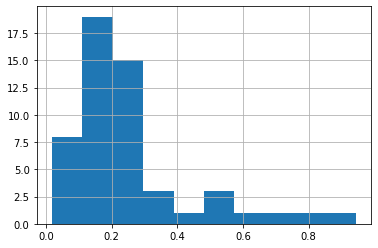

In [37]:
neighborhoods["accessibility_index"].hist()

In [38]:
neighborhoods["POC_ratio"] = neighborhoods["F2020_PL_data_POC"]/neighborhoods["F2020_PL_data_TOT_POP"]

In [39]:
neighborhoods["POC_density"] = neighborhoods["F2020_PL_data_POC"]/neighborhoods["AREA_SQMI"]

In [40]:
import shapely

In [41]:
# reverse order to clockwise
neighborhoods['geometry'] = neighborhoods['geometry'].apply(lambda poly: shapely.geometry.polygon.orient(poly, -1))

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [44]:
neighborhoods.to_file("neighborhoods_data_aggregated.geojson", driver='GeoJSON')

/Users/ek/miniconda3/envs/cse512/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [42]:
import matplotlib.pyplot as plt

<AxesSubplot:>

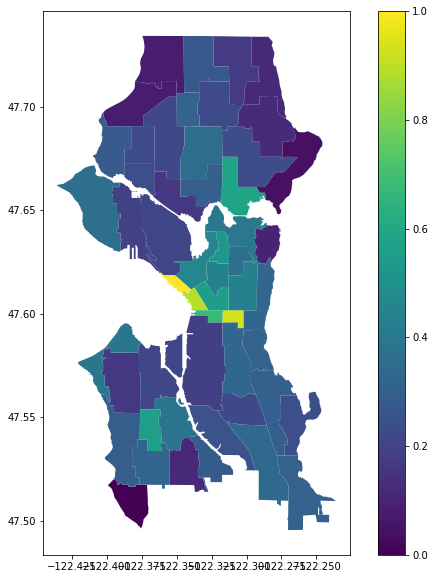

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
neighborhoods.plot(ax=ax, column='normalized_bike_index', legend=True)
# crosswalks.plot(ax=ax)

<AxesSubplot:>

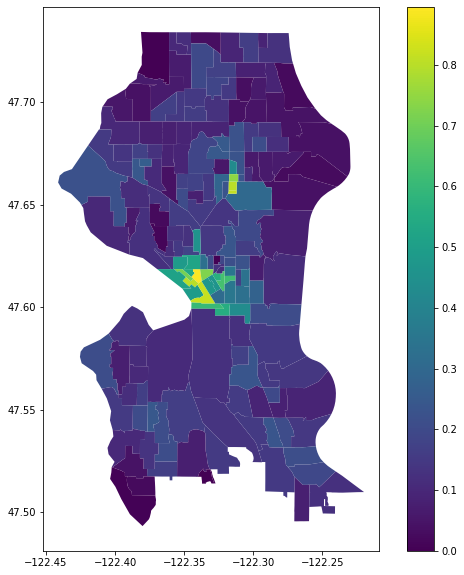

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
tracts.plot(ax=ax, column='accessibility_index', legend=True)
# crosswalks.plot(ax=ax)

Text(0, 0.5, 'accessibility')

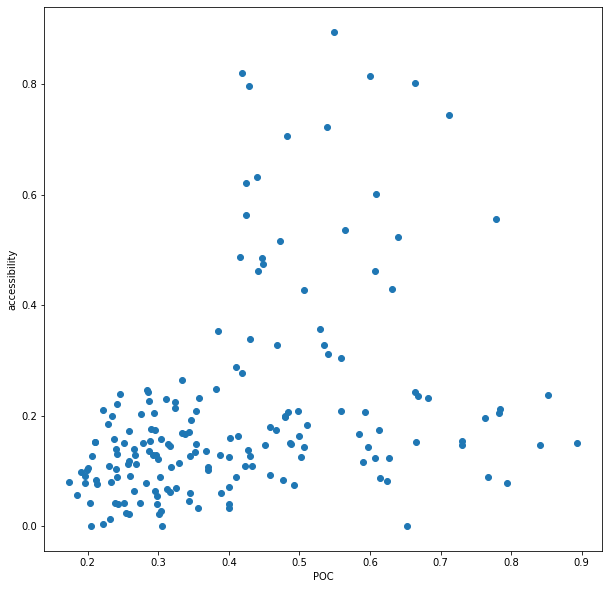

In [85]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=tracts['POC_ratio'], y=tracts["accessibility_index"])
ax.set_xlabel("POC")
ax.set_ylabel("accessibility")

In [69]:
import shapely

In [80]:
print(shapely.geometry.polygon.orient(tracts["geometry"][1], -1))

POLYGON ((-122.296404783966 47.7265108455789, -122.294610784419 47.7264958488696, -122.294571784565 47.7264958493073, -122.293570783924 47.7264868510905, -122.29226478478 47.7264758539416, -122.290906784563 47.7264638566216, -122.289558783607 47.7264498595976, -122.289606792767 47.7282788596933, -122.289654800872 47.7300998586463, -122.289704809076 47.7319318582122, -122.289751816265 47.7337338584922, -122.288413816552 47.7337308610941, -122.28704881607 47.7337228638495, -122.286709816944 47.7337258642781, -122.286321816912 47.7337308652036, -122.285955816416 47.7337338664089, -122.284661816852 47.7337388692277, -122.284536816424 47.7337388692267, -122.283756816471 47.7337368710844, -122.282010816921 47.7337388745943, -122.280632816024 47.7337368778206, -122.279631816365 47.7337368800783, -122.274926816808 47.7337338895106, -122.274395816072 47.7337338913287, -122.274366816057 47.7334918909995, -122.273586786733 47.7269298933302, -122.273517785443 47.7266818939128, -122.273489785049 47

In [72]:
-122.296381776429 47.7247038460316
-122.294610784419 47.7264958488696

SyntaxError: invalid syntax (3532017866.py, line 1)

In [54]:
dir(tracts["geometry"][1])

['__and__',
 '__array_interface__',
 '__bool__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__geom__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__p__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '__xor__',
 '_array_interface_base',
 '_crs',
 '_ctypes',
 '_ctypes_data',
 '_empty',
 '_exterior',
 '_geom',
 '_get_coords',
 '_interiors',
 '_is_empty',
 '_lgeos',
 '_ndim',
 '_other_owned',
 '_repr_svg_',
 '_set_coords',
 '_set_geom',
 'almost_equals',
 'area',
 'array_interface_base',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'ctypes',
 'difference',
 'disjoint',
 'distance',

In [78]:
least_accessible = list(tracts["accessibility_index"].sort_values()[:10].index)

In [81]:
most_POC = list(tracts["POC_ratio"].sort_values()[-11:-1].index)

In [82]:
least_accessible

[178, 177, 8, 105, 176, 93, 13, 175, 81, 49]

In [83]:
most_POC

[172, 149, 131, 161, 171, 173, 179, 170, 159, 160]